# Check package loads correctly

In [1]:
from mlops.config import MODEL_CONFIG

In [2]:
MODEL_CONFIG["models"]["churn"]

{'target': 'Exited',
 'drop_features': {'numerical': ['CustomerId', 'RowNumber'],
  'categorical': ['Surname']},
 'test_size': 0.2,
 'random_seed': 123456,
 'param_grid': {'mlp_classifier__hidden_layer_sizes': [[8, 1],
   [8, 6, 1],
   [16, 1],
   [16, 8, 1],
   [32, 16, 1]],
  'mlp_classifier__activation': ['relu', 'tanh'],
  'mlp_classifier__learning_rate_init': [0.001, 0.01],
  'mlp_classifier__max_iter': [1000]},
 'metadata': {'author': 'ML Team',
  'description': 'Churn Prediction Model',
  'version': '1.0.0',
  'tags': ['production', 'classification', 'churn']}}

# Transformers

In [3]:
import numpy as np
import pandas as pd
from mlops.transformers import OutlierClipper, FeatureSelector

np.random.seed(MODEL_CONFIG["models"]['churn']['random_seed'])
n_samples = 1000

In [4]:
X = np.random.normal(0, 1, (n_samples, 3))

# Add some outliers:
X[0:10] = X[0:10] * 10

# Create a target variable with some correlation to features
y = 2 * X[:, 0] + 0.5 * X[:, 1] - X[:, 2] + np.random.normal(0, 0.1, n_samples)

## Test OutlierClipper

In [5]:
clipper = OutlierClipper(factor=1.5)
X_clipped = clipper.fit_transform(X)

### Compare original vs clipped data 


In [6]:
df_comparison = pd.DataFrame({
    'Original_Feature1': X[:, 0],
    'Clipped_Feature1': X_clipped[:, 0]
})
print("Original vs Clipped Statistics for Feature 1:")
print(df_comparison.describe())

Original vs Clipped Statistics for Feature 1:
       Original_Feature1  Clipped_Feature1
count        1000.000000       1000.000000
mean           -0.020330          0.007592
std             1.353531          1.050163
min           -21.045692         -2.800057
25%            -0.679621         -0.679621
50%             0.022939          0.022939
75%             0.734003          0.734003
max             7.215552          2.854439


## Test FeatureSelector

In [7]:
selector = FeatureSelector(threshold=0.25)
X_selected = selector.fit_transform(X_clipped, y)

### Compare original vs selected features

In [8]:
print("\nSelected features mask:", selector.selected_features_)
print(f"Original features: {X.shape[1]}")
print(f"Selected features: {X_selected.shape[1]}")


Selected features mask: [ True False  True]
Original features: 3
Selected features: 2


## Visualize the results

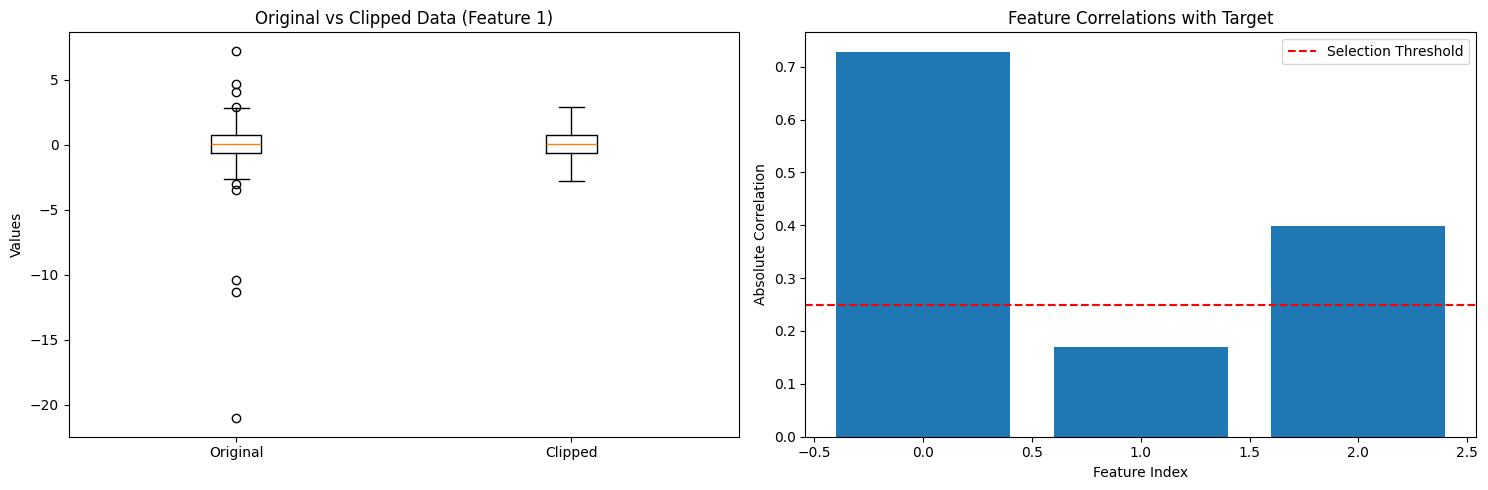

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot 1: Original vs Clipped Data
plt.subplot(121)
plt.boxplot([X[:, 0], X_clipped[:, 0]], tick_labels=['Original', 'Clipped'])  # Changed 'labels' to 'tick_labels'
plt.title('Original vs Clipped Data (Feature 1)')
plt.ylabel('Values')

# Plot 2: Feature Correlations
correlations = [abs(np.corrcoef(X_clipped[:, i], y)[0, 1]) for i in range(X_clipped.shape[1])]
plt.subplot(122)
plt.bar(range(len(correlations)), correlations)
plt.axhline(y=selector.threshold, color='r', linestyle='--', label='Selection Threshold')
plt.title('Feature Correlations with Target')
plt.xlabel('Feature Index')
plt.ylabel('Absolute Correlation')
plt.legend()

plt.tight_layout()

plt.show()